# Inspecting atlas shipped in BrainLM

The original data processing code of BrainLM extract time sereis using A424 atlas in an unidentified MNI152 template in 2mm space. 

There were no sainty check to make sure all the functional data and the atlas are in the same space.
Hence for the purpose of running the BrainLM tutorial using the nilearn test dataset developmental dataset, and using as much of the original code as possible, we need to manually resample the atlas to match the nilearn developmental dataset.

In [1]:
from nilearn import plotting, image
from nilearn.datasets import MNI152_FILE_PATH, fetch_development_fmri
import matplotlib.pyplot as plt
from importlib.resources import files
from nilearn._utils import check_niimg
import numpy as np
from hfplayground.data import downsample_for_tutorial

In [2]:
downsample_atlas = downsample_for_tutorial(files('hfplayground') / 'data/brainlm/atlases/A424+2mm.nii.gz', '/tmp/')
downsample_mni = downsample_for_tutorial(MNI152_FILE_PATH, '/tmp/')

The original A424 atlas is very strictly following the grey matter, and includes the cerebellum. 

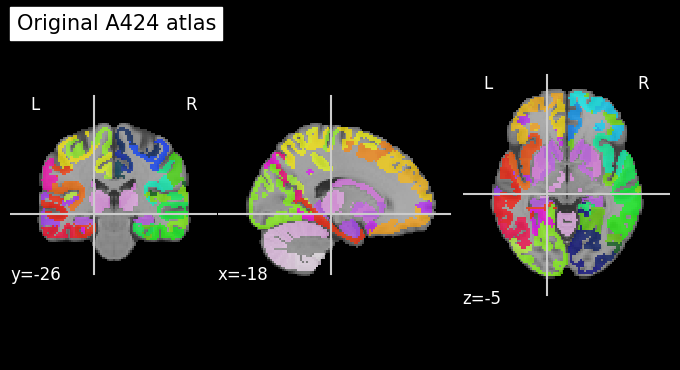

In [3]:
plotting.plot_roi(files('hfplayground') / 'data/brainlm/atlases/A424+2mm.nii.gz', title="Original A424 atlas", black_bg=True)

The nilearn test dataset has been downsampled to voxel size 4mm^3, so we have to resample the atlas accordingly. 

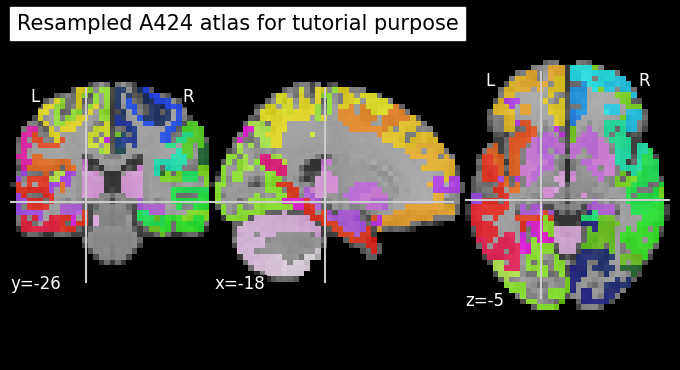

In [4]:
plotting.plot_roi(downsample_atlas, downsample_mni, title="Resampled A424 atlas for tutorial purpose")

Let's overlay it on real data. 

We can see that the cerebellum is cut off in the EPI scan. This is a very common compromise. 

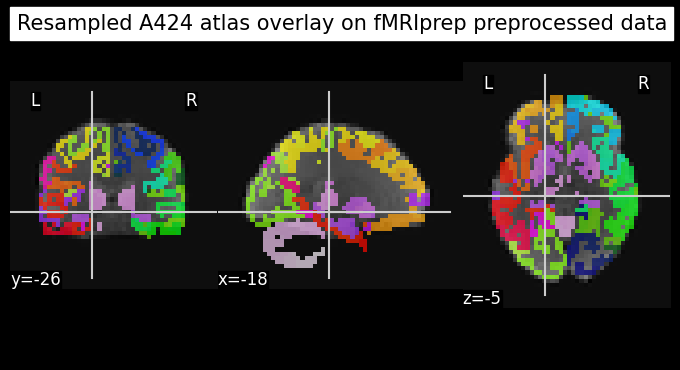

In [5]:
bg_img = image.load_img('../data/external/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
plotting.plot_roi(downsample_atlas, bg_img=bg_img.slicer[..., 0], title="Resampled A424 atlas overlay on fMRIprep preprocessed data")

Overlaying on data after denoising. Since I used a MNI template brain mask, we can see the missing cerebellum is filled up. 

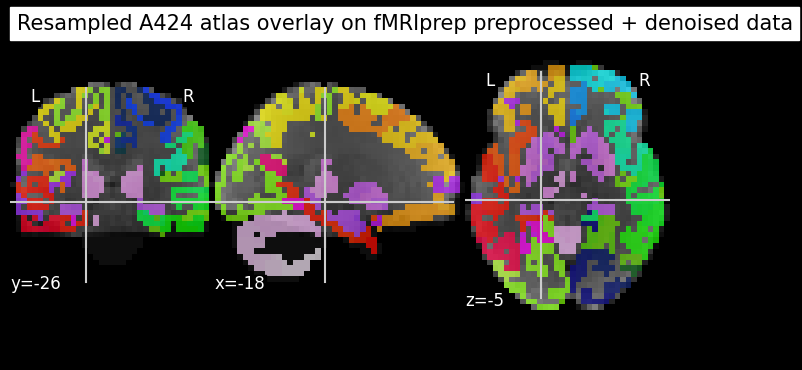

In [6]:
bg_img = image.load_img('../data/interim/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preprocSimple_bold.nii.gz')
plotting.plot_roi(downsample_atlas, bg_img=bg_img.slicer[..., 0], title="Resampled A424 atlas overlay on fMRIprep preprocessed + denoised data")